# NYC Apartment Search

_[Project prompt](https://docs.google.com/document/d/1BYVyFBDcTywdUlanH0ysfOrNWPgl7UkqXA7NeewTzxA/edit#heading=h.bpxu7uvknnbk)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add code as you wish._

_**All code below should be consider "pseudo-code" - not functional by itself, and only an idea of a possible approach.**_

## Setup

In [1]:
# All import statements needed for the project, for example:
import math
from datetime import datetime
from datetime import date
import numpy as np
import json
import pathlib
import urllib.parse
import psycopg2
import psycopg2.extras
import geoalchemy2 as gdb
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geoplot as gplt
import geoplot.crs as gcrs
from pathlib import PosixPath
from pyproj import CRS, Transformer
from shapely.ops import transform
import geodatasets
import contextily as cx
import seaborn as sns
import pandas as pd
import requests
import shapely
import sqlalchemy as db
import os
from shapely.geometry import Point
from sqlalchemy.orm import declarative_base

In [2]:
# Any constants you might need; some have been added for you

# Where data files will be read from/written to - this should already exist
DATA_DIR = pathlib.Path("data")
COMPLAINTS_DATE_DIR =  pathlib.Path("data/311_data")
ZIPCODE_DATA_FILE = DATA_DIR / "zipcodes" / "nyc_zipcodes.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

APP_TOKEN = "noFU7vdLMu3RKtmWOyOqkOi2x"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/resource/"
NYC_DATA_311 = "erm2-nwe9.json"
NYC_DATA_TREES = "5rq2-4hqu.json"

DB_NAME = "Final_Project"
DB_USER = "postgres"
DB_PASSWORD = "Sml123321"
DB_URL = f"postgres+psycopg2://{DB_USER}@localhost/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"

crs='EPSG:4326'

rent_month_dict = {}
# directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("queries")

In [3]:
# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

## Part 1: Data Preprocessing

In [4]:
def download_nyc_311_data(url, force=False):
    
    json_files = [f"{i}.json" for i in range(35)]
    filenames = [COMPLAINTS_DATE_DIR / i for i in json_files ]
    
    if not COMPLAINTS_DATE_DIR.exists():
        COMPLAINTS_DATE_DIR.mkdir()
    
    limit = 1_000_000
    for filename in filenames:
        if force or not filename.exists():
            print(f"Downloading {url} to {filename}...")
            offset = int(filename.stem) * 1_000_000
            all_entries = []
            selected_columns = ["unique_key", "created_date", "complaint_type", "incident_zip", "location"]

    
            soql_query = f"{url}?$$app_token={APP_TOKEN}&$select={','.join(selected_columns)}&$limit={limit}&$offset={offset}"
            response = requests.get(soql_query)
            
            if response.status_code == 200: 
                entries = response.json()
                if not entries:
                    break 
            else:
                print(f"cannot access url error code{response.status_code}")
                break
        
        
            with open(filename, "w") as f:
                json.dump(entries, f)
            print(f"Done downloading {filename}.")
            
    print(f"start loading data from {filenames[0]} to {filenames[-1]}...")
    return filenames[:2]

In [5]:
def download_nyc_tree_data(url, force=False):
    
    url_path = urllib.parse.urlparse(url).path.split('/')[-1]
    filename = DATA_DIR / url_path
    
    if not DATA_DIR.exists():
        DATA_DIR.mkdir()

    if force or not filename.exists():
        print(f"Downloading {url} to {filename}...")
        
        limit = 1_000_000
        offset = 0
        all_entries = []
        selected_columns = ["created_at", "tree_id", "zipcode", "the_geom", "spc_common", "health", "status"]
        end = 1_000_000
        
        while offset < end:  
            total = limit+offset
            print(f"start from {offset} and total is {total}")
            soql_query = f"{url}?$$app_token={APP_TOKEN}&$select={','.join(selected_columns)}&$limit={limit}&$offset={offset}"
            response = requests.get(soql_query)
            if response.status_code == 200: 
                entries = response.json()
                if not entries:
                    break 
                all_entries.extend(entries)
                offset += limit
            else:
                print(f"cannot access url error code{response.status_code}")
                break
        
        
        with open(filename, "w") as f:
            json.dump(all_entries, f)
        print(f"Done downloading {url}.")

    else:
        print(f"Reading from {filename}...")

    return filename

In [6]:
def load_and_clean_zipcodes(zipcode_datafile):
    global unique_zipcodes
    gdf = gpd.read_file("data/nyc_zipcodes/nyc_zipcodes.shp")
    gdf = gdf.to_crs(4326)
    zip_code = gdf[["ZIPCODE", "geometry"]].copy()
    unique_zipcodes_df = zip_code.drop_duplicates(subset = ["ZIPCODE"], keep = "last").reset_index()
    unique_zipcodes = unique_zipcodes_df["ZIPCODE"]
    return unique_zipcodes_df

In [7]:
def download_and_clean_311_data():
    Service_Requests_url = f"{BASE_NYC_DATA_URL}{NYC_DATA_311}"

    filenames = download_nyc_311_data(Service_Requests_url)

    interactions_geo_data_frames = []

    # Iterate through each file in the directory
    for filename in filenames:
        now = datetime.now()

        current_time = now.strftime("%H:%M:%S")
        print(f"Current Time = {current_time} input_file {filename} begin" )
        interactions_geo_data_frame = gpd.GeoDataFrame(pd.read_json(filename, dtype='object'))
        #interactions_geo_data_frame = gpd.read_file(file_path, dtype='object')
    
        if 'location' in interactions_geo_data_frame.columns:
            #if 'longitude' in interactions_geo_data_frame['location'].columns and 'latitude' in interactions_geo_data_frame['location'].columns:
                interactions_geo_data_frame['longitude'] = interactions_geo_data_frame['location'].apply(
                    lambda loc: loc.get('longitude') if isinstance(loc, dict) else None
                )
                interactions_geo_data_frame['latitude'] = interactions_geo_data_frame['location'].apply(
                    lambda loc: loc.get('latitude') if isinstance(loc, dict) else None
                )


                geometry = gpd.GeoSeries(
                    interactions_geo_data_frame.apply(
                        lambda row: Point(float(row['longitude']), float(row['latitude'])) if not pd.isna(row['longitude']) and not pd.isna(row['latitude']) else None,
                        axis=1
                    ),
                    crs='EPSG:4326'
                )

        

        if 'location' in interactions_geo_data_frame.columns:
                interactions_geo_data_frame.drop(columns=['location'], inplace=True)
        if 'longitude' in interactions_geo_data_frame.columns:
                interactions_geo_data_frame.drop(columns=['longitude'], inplace=True)
        if 'latitude' in interactions_geo_data_frame.columns:
                interactions_geo_data_frame.drop(columns=['latitude'], inplace=True)
    
        interactions_geo_data_frame.set_geometry(geometry, inplace=True)
        
        interactions_geo_data_frame = interactions_geo_data_frame.dropna(subset=['incident_zip'])
        interactions_geo_data_frame = interactions_geo_data_frame[interactions_geo_data_frame["incident_zip"].isin(unique_zipcodes)]

        interactions_geo_data_frame['created_date'] = pd.to_datetime(interactions_geo_data_frame['created_date'], format='%Y-%m-%dT%H:%M:%S.%f')

        interactions_geo_data_frames.append(interactions_geo_data_frame)
    
    
    current_time = now.strftime("%H:%M:%S")
    print(f"Current Time = {current_time} load file done" )
    interactions_geo_df = gpd.GeoDataFrame(pd.concat(interactions_geo_data_frames, ignore_index=True, sort=True))
    current_time = now.strftime("%H:%M:%S")
    print(f"Current Time = {current_time} concat file done" )
    interactions_geo_df.crs = interactions_geo_data_frames[0].crs
    interactions_geo_data_frames.clear()
    interactions_geo_df = interactions_geo_df.drop_duplicates(subset=['unique_key']).reset_index(drop=True)
    now = datetime.now()

    current_time = now.strftime("%H:%M:%S")
    print(f"Current Time = {current_time} done normalized data 311" )
    
    return interactions_geo_df

In [8]:
def download_and_clean_tree_data():
    Trees_url = f"{BASE_NYC_DATA_URL}{NYC_DATA_TREES}"
    filename = download_nyc_tree_data(Trees_url)
    trees_gdf = gpd.GeoDataFrame(pd.read_json(filename), dtype='object')
    convert_dict = {
        "tree_id" : int,
        "spc_common" :str,
        "health": str,
        "status": str,
        "the_geom" : "geometry",
        "zipcode":str
    }
    
    trees_gdf['the_geom'] = gpd.GeoSeries(
        trees_gdf['the_geom'].apply(lambda x: Point(x['coordinates'])), crs='EPSG:4326'
    )
    
    trees_gdf_normalized = gpd.GeoDataFrame(trees_gdf.astype(convert_dict))
    trees_gdf_normalized = gpd.GeoDataFrame(trees_gdf_normalized[trees_gdf_normalized["zipcode"].isin(unique_zipcodes)])
    
    return trees_gdf_normalized

In [9]:
def load_and_clean_zillow_data(ZILLOW_DATA_FILE):
    global rent_month_dict
    zillow_rent_data = pd.read_csv(ZILLOW_DATA_FILE)
    NY_rent_date = zillow_rent_data[zillow_rent_data["City"] == "New York"]
    NY_rent_date = NY_rent_date.reset_index(drop=True)
    NY_rent_date_sub = NY_rent_date.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName', 'State','City','Metro','CountyName'])
    column_names = NY_rent_date_sub.columns.tolist()
    for i,j in enumerate(column_names):
        if i > 0:
            rent_month_dict[j] = i-1
    return NY_rent_date_sub

In [10]:
def load_all_data():
    geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    print(f"load zipcode data done")
    geodf_311_data = download_and_clean_311_data()
    print(f"load 311 data done")
    geodf_tree_data = download_and_clean_tree_data()
    print(f"load trees data done")
    df_zillow_data = load_and_clean_zillow_data(ZILLOW_DATA_FILE)
    print(f"load rents data done")
    return (
        geodf_zipcode_data,
        geodf_311_data,
        geodf_tree_data,
        df_zillow_data
    )

In [11]:
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

load zipcode data done
start loading data from data/311_data/0.json to data/311_data/34.json...
Current Time = 14:15:46 input_file data/311_data/0.json begin
Current Time = 14:16:44 input_file data/311_data/1.json begin
Current Time = 14:16:44 load file done
Current Time = 14:16:44 concat file done
Current Time = 14:17:43 done normalized data 311
load 311 data done
Reading from data/5rq2-4hqu.json...
load trees data done
load rents data done


In [12]:
# Show basic info about each dataframe
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   index     248 non-null    int64   
 1   ZIPCODE   248 non-null    object  
 2   geometry  248 non-null    geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 5.9+ KB


In [13]:
# Show first 5 entries about each dataframe
geodf_zipcode_data.head()

,index,ZIPCODE,geometry
0,0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,1,11213,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,2,11212,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,3,11225,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,4,11218,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


In [14]:
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1973903 entries, 0 to 1973902
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   complaint_type  object        
 1   created_date    datetime64[ns]
 2   geometry        geometry      
 3   incident_zip    object        
 4   unique_key      object        
dtypes: datetime64[ns](1), geometry(1), object(3)
memory usage: 75.3+ MB


In [15]:
geodf_311_data.head()

,complaint_type,created_date,geometry,incident_zip,unique_key
0,Derelict Vehicles,2023-11-28 12:00:00,POINT (-73.76696 40.65347),11430,59557583
1,Derelict Vehicles,2023-11-28 12:00:00,POINT (-73.93298 40.85212),10033,59556940
2,Graffiti,2023-11-28 02:04:10,POINT (-73.99161 40.61774),11204,59557706
3,Street Light Condition,2023-11-28 00:44:00,POINT (-73.93104 40.85051),10033,59559656
4,Street Light Condition,2023-11-28 00:33:00,POINT (-74.06476 40.60801),10305,59558968


In [16]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 682853 entries, 0 to 683787
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   created_at  682853 non-null  object  
 1   tree_id     682853 non-null  int64   
 2   zipcode     682853 non-null  object  
 3   the_geom    682853 non-null  geometry
 4   spc_common  682853 non-null  object  
 5   health      682853 non-null  object  
 6   status      682853 non-null  object  
dtypes: geometry(1), int64(1), object(5)
memory usage: 41.7+ MB


In [17]:
geodf_tree_data.head()

,created_at,tree_id,zipcode,the_geom,spc_common,health,status
0,2015-08-27 00:00:00,180683,11375,POINT (-73.84422 40.72309),red maple,Fair,Alive
1,2015-09-03 00:00:00,200540,11357,POINT (-73.81868 40.79411),pin oak,Fair,Alive
2,2015-09-05 00:00:00,204026,11211,POINT (-73.93661 40.71758),honeylocust,Good,Alive
3,2015-09-05 00:00:00,204337,11211,POINT (-73.93446 40.71354),honeylocust,Good,Alive
4,2015-08-30 00:00:00,189565,11215,POINT (-73.97598 40.66678),American linden,Good,Alive


In [18]:
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Columns: 106 entries, RegionName to 2023-09-30
dtypes: float64(105), int64(1)
memory usage: 120.2 KB


In [19]:
df_zillow_data.head()

,RegionName,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,...,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
0,11385,NaN,2087.527084,NaN,2149.924252,2166.263698,2148.992886,2190.098591,2264.966715,2297.900917,...,2935.808220,2895.699421,2873.209025,2881.906361,2913.546218,2963.964134,3005.735342,3034.413822,3064.476503,3079.585783
1,11208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2508.670432,2588.030194,2613.790654,2585.561351,2633.200754,2672.038493,2806.918757,2765.224364,2737.547470,2728.733333
2,11236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2285.460026,2362.500000
3,10467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2145.642295,2155.617718,2172.346611,2160.962748,2110.533203,2180.323655,2276.372290,2334.204728,2353.686402,2423.888889
4,11373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2199.459063,2255.604528,2262.101623,2271.514956,2250.182334,2231.959479,2257.413993,2247.592851,2302.557354,2292.994444


## Part 2: Storing Data

In [20]:
def setup_new_postgis_database(username, db_name, password):
    conn = psycopg2.connect(database=db_name,
                        host="localhost",
                        user=username,
                        password=password,
                        port="5432")
    return conn

In [21]:
conn = setup_new_postgis_database(DB_USER, DB_NAME, DB_PASSWORD)

In [22]:
cur = conn.cursor()

### Creating Tables


These are just a couple of options to creating your tables; you can use one or the other, a different method, or a combination.

In [23]:
# if using SQL (as opposed to SQLAlchemy), define the SQL statements to create your 4 tables
ZIPCODE_SCHEMA = """
CREATE TABLE IF NOT EXISTS NYC_zipcodes
(
    id serial PRIMARY KEY,
    zipcode TEXT, 
    geometry geometry(Polygon, 4326),
    CONSTRAINT unique_zipcode UNIQUE (zipcode)
);
"""

NYC_311_SCHEMA = """
CREATE TABLE IF NOT EXISTS NYC_complaints
(
    id INTEGER PRIMARY KEY, 
    created_date date,
    zipcode TEXT,
    complaint_type TEXT,
    location geometry(Point, 4326),
    CONSTRAINT zip_code
        FOREIGN KEY(zipcode)
            REFERENCES NYC_zipcodes(zipcode)
);
"""

NYC_TREE_SCHEMA = """
CREATE TABLE IF NOT EXISTS NYC_trees
(
    id INTEGER PRIMARY KEY, 
    created_date date,
    zipcode TEXT,
    location geometry,
    species TEXT,
    health TEXT,
    status TEXT,
    CONSTRAINT zip_code
        FOREIGN KEY(zipcode)
            REFERENCES NYC_zipcodes(zipcode)
);
"""

ZILLOW_SCHEMA = """
CREATE TABLE IF NOT EXISTS NYC_rents
(
    id serial PRIMARY KEY,
    zipcode TEXT,
    rents REAL[],  
    CONSTRAINT zip_code
        FOREIGN KEY(zipcode)
            REFERENCES NYC_zipcodes(zipcode)
);
"""

ZIPCODE_TABLE_INDEX = "CREATE INDEX IF NOT EXISTS zip_geo ON NYC_zipcodes USING GIST(geometry);"

COMLIANTS_TABLE_INDEX = "CREATE INDEX IF NOT EXISTS complaints_location ON NYC_complaints USING GIST(location);"

TREES_TABLE_INDEX = "CREATE INDEX IF NOT EXISTS tree_location ON NYC_trees USING GIST(location);"

In [24]:
# create that required schema.sql file
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA)
    f.write(NYC_311_SCHEMA)
    f.write(NYC_TREE_SCHEMA)
    f.write(ZILLOW_SCHEMA)
    f.write(f"{ZIPCODE_TABLE_INDEX}\n")
    f.write(f"{COMLIANTS_TABLE_INDEX}\n")
    f.write(f"{TREES_TABLE_INDEX}\n")

In [25]:
# Execute following queries to delete tables if already exits
# cur.execute("DROP TABLE IF EXISTS NYC_trees")
# cur.execute("DROP TABLE IF EXISTS NYC_complaints")
# cur.execute("DROP TABLE IF EXISTS NYC_rents")
# cur.execute("DROP TABLE IF EXISTS NYC_zipcodes")

In [26]:
# Execute the schema files to create tables
cur.execute(ZIPCODE_SCHEMA)
cur.execute(NYC_311_SCHEMA)
cur.execute(NYC_TREE_SCHEMA)
cur.execute(ZILLOW_SCHEMA)

In [27]:
cur.execute(ZIPCODE_TABLE_INDEX)
cur.execute(COMLIANTS_TABLE_INDEX)
cur.execute(TREES_TABLE_INDEX)

In [28]:
conn.commit()

### Add Data to Database


#### Option 1: SQL

In [29]:
def zipcodes_write_to_table(geodf_zipcode_data):
    for zipcode, geo in zip(geodf_zipcode_data['ZIPCODE'], geodf_zipcode_data['geometry'].to_wkt()): #insert into databse
        query = '''
            INSERT INTO  NYC_zipcodes(zipcode, geometry)
            VALUES 
                (%s, ST_GeomFromText(%s, 4326))
            ''' 
        cur.execute(query, (zipcode, geo))

In [30]:
def complaints_write_to_table(geodf_311_data):
    for id_, created_date, zipcode, complaint_type, geo in zip(geodf_311_data['unique_key'], geodf_311_data['created_date'], geodf_311_data['incident_zip'], geodf_311_data['complaint_type'], geodf_311_data['geometry'].to_wkt()): #insert into databse
        query = '''
            INSERT INTO NYC_complaints(id, created_date, zipcode, complaint_type, location)
            VALUES (%s, %s, %s, %s, ST_SetSRID(ST_GeomFromText(%s), 4326))
            '''
        cur.execute(query, (id_, created_date, zipcode, complaint_type, geo))

In [31]:
def trees_write_to_table(geodf_tree_data):
    for id_, created_date, zipcode, specices, health, status, geo in zip(geodf_tree_data['tree_id'], geodf_tree_data['created_at'], 
                                                                         geodf_tree_data['zipcode'], geodf_tree_data['spc_common'], 
                                                                         geodf_tree_data['health'], geodf_tree_data['status'], 
                                                                         geodf_tree_data['the_geom'].to_wkt()): #insert into databse
        query = '''
                INSERT INTO NYC_trees(id, created_date, zipcode, species, health, status, location)
                VALUES (%s, %s, %s, %s, %s, %s, ST_SetSRID(ST_GeomFromText(%s), 4326))
                '''
        cur.execute(query, (id_, created_date, zipcode, specices, health, status, geo))

In [32]:
def rents_write_to_table(df_zillow_data):
    all_rows_data = []

    for index, row in df_zillow_data.iterrows():
        row_data = row.iloc[1:].tolist()
        all_rows_data.append(row_data)
    
    for zipcode, rent in zip(df_zillow_data['RegionName'], all_rows_data): #insert into databse
        query = '''
                INSERT INTO  NYC_rents(zipcode, rents)
                VALUES (%s, %s)
                '''
        cur.execute(query, (zipcode, rent))

In [33]:
tablename_to_dataframe = {
    "zipcodes": geodf_zipcode_data,
    "complaints": geodf_311_data,
    "trees": geodf_tree_data,
    "rents": df_zillow_data,
}

In [34]:
def write_dataframes_to_table(tablename_to_dataframe):
    zipcodes_write_to_table(tablename_to_dataframe['zipcodes'])
    print("write zipcodes to db done")
    complaints_write_to_table(tablename_to_dataframe['complaints'])
    print("write complaints to db done")
    trees_write_to_table(tablename_to_dataframe['trees'])
    print("write trees to db done")
    rents_write_to_table(tablename_to_dataframe['rents'])
    print("write rents to db done")

In [35]:
#write the dataframes to tables
#write_dataframes_to_table(tablename_to_dataframe)

In [36]:
# Show the number of entries of each table
cur.execute("SELECT count(*) from NYC_zipcodes")
cur.fetchall()

[(248,)]

In [37]:
# Show a sample entries of each table
cur.execute("SELECT zipcode, LEFT(ST_AsText(geometry), 50) from NYC_zipcodes Limit 2") #count the number of ratios in the database
cur.fetchall()[1]

('11213', 'POLYGON((-73.937398 40.67973,-73.934872 40.679593,')

In [38]:
cur.execute("SELECT count(*) from NYC_complaints")
cur.fetchall()

[(33233422,)]

In [39]:
cur.execute("SELECT id, zipcode, ST_AsText(location) from NYC_complaints Limit 2") #count the number of ratios in the database
cur.fetchall()

[(56471260, '11365', 'POINT(-73.794933 40.737582)'),
 (56473010, '10457', 'POINT(-73.902853 40.851232)')]

In [40]:
cur.execute("SELECT count(*) from NYC_trees")
cur.fetchall()

[(682853,)]

In [41]:
cur.execute("SELECT id, zipcode, ST_AsText(location) from NYC_trees Limit 2") #count the number of ratios in the database
cur.fetchall()

[(180683, '11375', 'POINT(-73.844215 40.723092)'),
 (200540, '11357', 'POINT(-73.818679 40.794111)')]

In [42]:
cur.execute("SELECT count(*) from NYC_rents")
cur.fetchall()

[(145,)]

In [43]:
cur.execute("SELECT id, zipcode, array_to_string(rents, ', ') AS rent FROM NYC_rents;") #count the number of ratios in the database
cur.fetchall()[1]

(2,
 '11208',
 'NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 2334.735, 2372.3096, 2408.2073, 2451.158, 2473.9316, 2498.065, 2479.6006, 2487.125, 2504.0781, 2508.6704, 2588.0303, 2613.7908, 2585.5613, 2633.2007, 2672.0386, 2806.9187, 2765.2244, 2737.5474, 2728.7334')

## Part 3: Understanding the Data

### Query 1

In [44]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    with open(outfile, "w") as f:
        f.write(query)

In [45]:
def write_all_queries_to_file():    
    write_query_to_file(QUERY_1, QUERY_1_FILENAME)
    write_query_to_file(QUERY_2, QUERY_2_FILENAME)
    write_query_to_file(QUERY_3, QUERY_3_FILENAME)
    write_query_to_file(QUERY_4, QUERY_4_FILENAME)
    write_query_to_file(QUERY_5, QUERY_5_FILENAME)
    write_query_to_file(QUERY_6, QUERY_6_FILENAME)

In [46]:
QUERY_1_FILENAME = QUERY_DIR / "Query1_311_complaints_by_zipcodes.sql"
start_date = date(2022, 10, 1)
end_date = date(2023, 9, 30)

QUERY_1 = f'''
    SELECT zipcode, COUNT(*) AS num_complaints
    FROM NYC_complaints
    WHERE created_date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY zipcode
    ORDER BY num_complaints DESC;
'''

In [47]:
QUERY_2_FILENAME = QUERY_DIR / "Query2_top_10_zipcodes_by_trees.sql"

QUERY_2 = '''
        SELECT zipcode, COUNT(*) AS num_trees
        FROM NYC_trees
        GROUP BY zipcode
        ORDER BY num_trees DESC
        LIMIT 10;
'''

In [48]:
QUERY_3_FILENAME = QUERY_DIR / "Query3_Aug_2023_top_10_zipcodes_rents_by_trees.sql"
i = rent_month_dict['2023-08-31']
# Query to find the average rent for each zip code in the top 10 zip codes with the most trees
QUERY_3 = f'''
    SELECT r.zipcode, TO_CHAR(rent_element, '9,999.99') AS avg_rent
    FROM (
        SELECT
            r.zipcode,
            r.rents[{i}] AS rent_element
        FROM
            NYC_rents r

    ) r
    JOIN (
        SELECT zipcode
        FROM NYC_trees
        GROUP BY zipcode
        ORDER BY COUNT(*) DESC
        LIMIT 10
    ) t ON r.zipcode = t.zipcode
    ORDER BY avg_rent DESC;
'''

In [49]:
QUERY_4_FILENAME = QUERY_DIR / "Query4_zipcodes_rents_tress_complaints_correlation_by_rents.sql"
i = rent_month_dict['2023-01-31']
# Query to find the average rent for each zip co de in the top 10 zip codes with the most trees
QUERY_4 = f'''
    SELECT 
        r.zipcode, 
        TO_CHAR(rent_element, '9,999.99') AS avg_rent,
        t.num_trees, 
        c.num_complaints 
    FROM(
        (
            SELECT
                zipcode,
                rents[{i}] AS rent_element
            FROM
                NYC_rents r
            WHERE NOT (rents[96] = 'NaN')
            ORDER BY rents[{i}] 
            LIMIT 5
        ) 
        UNION ALL 
        ( 
            SELECT 
                zipcode,
                rents[{i}] AS rent_element
            FROM
                NYC_rents r
            WHERE NOT (rents[96] = 'NaN')
            ORDER BY rents[{i}] DESC
            LIMIT 5
        )
    )AS r
    JOIN (
        SELECT 
            zipcode, 
            COUNT(*) AS num_trees
        FROM NYC_trees
        GROUP BY zipcode
    ) t ON r.zipcode = t.zipcode
    JOIN (
        SELECT 
            zipcode, 
            COUNT(*) AS num_complaints
        FROM NYC_complaints
        GROUP BY zipcode
    ) c ON r.zipcode = c.zipcode
    ORDER BY avg_rent DESC;
'''


In [50]:
QUERY_5_FILENAME = QUERY_DIR / "Query5_top_10_zipcodes_by_trees_by_geometry_location.sql"
# Query to find the average rent for each zip co de in the top 10 zip codes with the most trees
QUERY_5 = f'''
    SELECT
        z.zipcode,
        COUNT(t.id) AS num_trees
    FROM
        NYC_zipcodes z
    JOIN
        NYC_trees t ON ST_Within(t.location, z.geometry)
    GROUP BY
        z.zipcode
    ORDER BY
        num_trees DESC
    LIMIT 10;
'''

In [51]:
QUERY_6_FILENAME = QUERY_DIR / "Query6_near_compus_trees_infomation.sql"
# Query to find the average rent for each zip co de in the top 10 zip codes with the most trees
QUERY_6 = f'''
    SELECT
        id,
        species,
        health,
        status,
        ST_AsText(location) AS coordinate
    FROM
        NYC_trees
    WHERE
        ST_DWithin(
            location,
            ST_MakePoint(-73.96253174434912, 40.80737875669467)::geography,
            804.672  -- 0.5 mile in meters
        );

'''

In [52]:
write_all_queries_to_file()

In [53]:
#Execute and display result for query1
cur.execute(QUERY_1)
results = cur.fetchall()
for row in results:
    print(f"Zip Code: {row[0]}, Number of Complaints: {row[1]}")

Zip Code: 11226, Number of Complaints: 49518
Zip Code: 10467, Number of Complaints: 47508
Zip Code: 10468, Number of Complaints: 44201
Zip Code: 11385, Number of Complaints: 44065
Zip Code: 10452, Number of Complaints: 44032
Zip Code: 10457, Number of Complaints: 41638
Zip Code: 10458, Number of Complaints: 41275
Zip Code: 11207, Number of Complaints: 40334
Zip Code: 10456, Number of Complaints: 39919
Zip Code: 11201, Number of Complaints: 39450
Zip Code: 10453, Number of Complaints: 38192
Zip Code: 11208, Number of Complaints: 36905
Zip Code: 10031, Number of Complaints: 33962
Zip Code: 11221, Number of Complaints: 33276
Zip Code: 10466, Number of Complaints: 32684
Zip Code: 10032, Number of Complaints: 32127
Zip Code: 10025, Number of Complaints: 31195
Zip Code: 10462, Number of Complaints: 30866
Zip Code: 11238, Number of Complaints: 30305
Zip Code: 11230, Number of Complaints: 29725
Zip Code: 11368, Number of Complaints: 29425
Zip Code: 11220, Number of Complaints: 29141
Zip Code: 

In [54]:
#Execute and display result for query2
cur.execute(QUERY_2)
results = cur.fetchall()
for row in results:
    print(f"Zip Code: {row[0]}, Number of Trees: {row[1]}")

Zip Code: 10312, Number of Trees: 22186
Zip Code: 10314, Number of Trees: 16905
Zip Code: 10306, Number of Trees: 13030
Zip Code: 10309, Number of Trees: 12650
Zip Code: 11234, Number of Trees: 11253
Zip Code: 11385, Number of Trees: 10937
Zip Code: 11357, Number of Trees: 9449
Zip Code: 11207, Number of Trees: 8634
Zip Code: 11434, Number of Trees: 8274
Zip Code: 11208, Number of Trees: 8245


In [55]:
#Execute and display result for query3
cur.execute(QUERY_3)
results = cur.fetchall()
for row in results:
    print(f"Zip Code:{row[0]}, avg_rent:{row[1]}")

Zip Code:11385, avg_rent: 3,034.41
Zip Code:11207, avg_rent: 3,011.85
Zip Code:11208, avg_rent: 2,765.22
Zip Code:11434, avg_rent: 2,744.81
Zip Code:10314, avg_rent: 2,467.05
Zip Code:11357, avg_rent: 2,417.08
Zip Code:10306, avg_rent: 2,330.52
Zip Code:11234, avg_rent: 2,292.07
Zip Code:10309, avg_rent: 1,733.61
Zip Code:10312, avg_rent: 1,709.74


In [56]:
#Execute and display result for query4
cur.execute(QUERY_4)
results = cur.fetchall()
for row in results:
    print(f"Zip Code:{row[0]}, avg_rent:{row[1]}, number of trees:{row[2]}, number of complaints: {row[3]}")

Zip Code:10007, avg_rent: 7,260.46, number of trees:355, number of complaints: 46393
Zip Code:10282, avg_rent: 7,058.61, number of trees:234, number of complaints: 5948
Zip Code:10013, avg_rent: 5,551.23, number of trees:1202, number of complaints: 149049
Zip Code:10069, avg_rent: 5,003.40, number of trees:119, number of complaints: 6272
Zip Code:10011, avg_rent: 4,789.54, number of trees:2134, number of complaints: 218408
Zip Code:11357, avg_rent: 1,788.94, number of trees:9449, number of complaints: 141854
Zip Code:10462, avg_rent: 1,776.66, number of trees:4234, number of complaints: 302108
Zip Code:10453, avg_rent: 1,762.64, number of trees:3050, number of complaints: 418417
Zip Code:10312, avg_rent: 1,644.01, number of trees:22186, number of complaints: 208250
Zip Code:10309, avg_rent: 1,456.13, number of trees:12650, number of complaints: 114994


In [57]:
#Execute and display result for query5
cur.execute(QUERY_5)
results = cur.fetchall()
for row in results:
    print(f"Zip Code:{row[0]}, number of trees:{row[1]}")

Zip Code:10312, number of trees:22186
Zip Code:10314, number of trees:16905
Zip Code:10306, number of trees:13030
Zip Code:10309, number of trees:12650
Zip Code:11234, number of trees:11253
Zip Code:11385, number of trees:10937
Zip Code:11357, number of trees:9449
Zip Code:11207, number of trees:8634
Zip Code:11434, number of trees:8274
Zip Code:11208, number of trees:8246


In [58]:
#Execute and display result for query6
cur.execute(QUERY_6)
results = cur.fetchall()
for row in results:
    print(f"Tree id:{row[0]}, species:{row[1]}, health:{row[2]}, status:{row[3]}, coordinates:{row[4]}")

Tree id:198514, species:pin oak, health:Good, status:Alive, coordinates:POINT(-73.96208 40.802301)
Tree id:209919, species:London planetree, health:Good, status:Alive, coordinates:POINT(-73.963315 40.808812)
Tree id:209921, species:London planetree, health:Good, status:Alive, coordinates:POINT(-73.963403 40.808745)
Tree id:203887, species:willow oak, health:Good, status:Alive, coordinates:POINT(-73.960719 40.805726)
Tree id:196440, species:American elm, health:Fair, status:Alive, coordinates:POINT(-73.964123 40.811145)
Tree id:209913, species:pin oak, health:Good, status:Alive, coordinates:POINT(-73.963121 40.809077)
Tree id:196605, species:American elm, health:Good, status:Alive, coordinates:POINT(-73.967158 40.807386)
Tree id:196614, species:nan, health:nan, status:Stump, coordinates:POINT(-73.9677 40.806503)
Tree id:188558, species:London planetree, health:Good, status:Alive, coordinates:POINT(-73.960529 40.803618)
Tree id:204127, species:Japanese zelkova, health:Fair, status:Alive,

In [59]:
# Test
!psql --dbname Final_Project -f queries/Query6_near_compus_trees_infomation.sql

   id   |        species         | health | status |         coordinate          
--------+------------------------+--------+--------+-----------------------------
 198514 | pin oak                | Good   | Alive  | POINT(-73.96208 40.802301)
 209919 | London planetree       | Good   | Alive  | POINT(-73.963315 40.808812)
 209921 | London planetree       | Good   | Alive  | POINT(-73.963403 40.808745)
 203887 | willow oak             | Good   | Alive  | POINT(-73.960719 40.805726)
 196440 | American elm           | Fair   | Alive  | POINT(-73.964123 40.811145)
 209913 | pin oak                | Good   | Alive  | POINT(-73.963121 40.809077)
 178550 | Norway maple           | Good   | Alive  | POINT(-73.957399 40.806903)
 189403 | Callery pear           | Fair   | Alive  | POINT(-73.958612 40.807541)
 196606 | honeylocust            | Good   | Alive  | POINT(-73.967199 40.807322)
 198512 | pin oak                | Good   | Alive  | POINT(-73.962306 40.802396)
 196541 | honeylocust      

## Part 4: Visualizing the Data

### Visualization 1

In [60]:
def plot_top_three_complaint_type_pie(dataframe):
    figure, axes = plt.subplots(figsize=(10, 10))
    complaint_type = dataframe['complaint_type']
    complaints_number = dataframe['complaints_number']
    explode = (0.05, 0, 0)  # Explode the first slice for emphasis 
    pie_colors = ['tab:blue', 'tab:red', 'tab:green']  # Use different colors for each slice

    axes.pie(complaints_number, labels=complaint_type, autopct='%1.1f%%',
            startangle=90, counterclock=False, explode=explode, colors=pie_colors, shadow=True)

    axes.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    axes.set_title("Top 3 Complaint Types between 2022-10-1 to 2023-9-30", color='darkred', fontsize=40)

    plt.show()

In [61]:
def get_data_for_visual_1():
    start_date = date(2022, 10, 1)
    end_date = date(2023, 9, 30)
    QUERY = f'''
    SELECT
        complaint_type,
        COUNT(*) AS complaints_number
    FROM
        NYC_complaints
    WHERE 
        created_date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY 
        complaint_type
    ORDER BY
        complaints_number DESC
    LIMIT 3;
    '''
    cur.execute(QUERY)
    result = cur.fetchall()
    df = pd.DataFrame(result, columns=['complaint_type', 'complaints_number'])
    return df

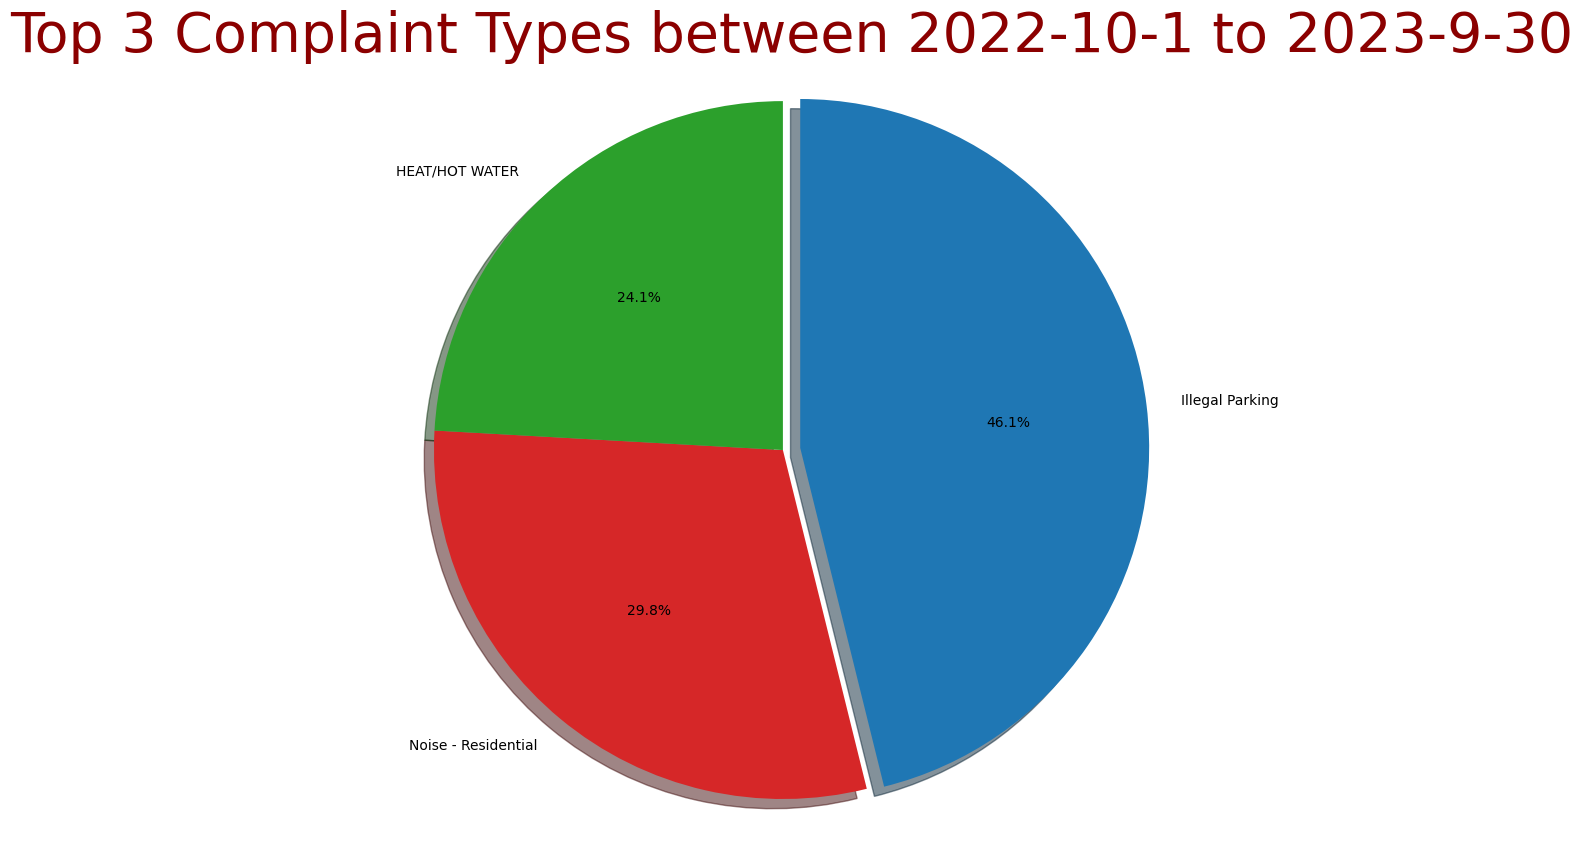

In [62]:
dataframe = get_data_for_visual_1()
plot_top_three_complaint_type_pie(dataframe)

### Visualization 2 

In [63]:
def plot_top_ten_complaint_type_for_10027(dataframe):
    figure, axes = plt.subplots(figsize=(40, 20))
    complaint_type = dataframe['complaint_type']
    complaints_number = dataframe['complaints_number']

    # Create a color map
    colors = plt.cm.viridis(np.linspace(0, 1, len(complaint_type)))

    bars = axes.bar(complaint_type, complaints_number, color=colors)

    axes.set_xlabel('Complaint Type', fontsize=24, color='darkblue')  # Set color for x-axis label
    axes.set_ylabel('Number of Complaints', fontsize=24, color='darkred')  # Set color for y-axis label
    axes.set_title("Top 10 Complaint Types for zip 10027 between 2018-10-1 to 2023-9-30", fontsize=40, color='purple')  # Set color for title

    # Increase font size of x-axis and y-axis ticks
    axes.tick_params(axis='both', labelsize=20)

    # Set tick positions at the middle of the bars
    middle_positions = [bar.get_x() + bar.get_width() / 2 for bar in bars]
    axes.set_xticks(middle_positions)
    axes.set_xticklabels(complaint_type, rotation=45, ha="right", fontsize=18, color='green')  # Set color for x-axis tick labels

    plt.show()

In [64]:
def get_data_for_visual_2():
    start_date = date(2018, 10, 1)
    end_date = date(2023, 9, 30)
    QUERY = f'''
    SELECT
        complaint_type,
        COUNT(*) AS complaints_number
    FROM
        NYC_complaints
    WHERE 
        created_date BETWEEN '{start_date}' AND '{end_date}'
        AND
        zipcode ='10027'
    GROUP BY 
        complaint_type
    ORDER BY
        complaints_number DESC
    LIMIT 10;
    '''
    cur.execute(QUERY)
    result = cur.fetchall()
    df = pd.DataFrame(result, columns=['complaint_type', 'complaints_number'])
    return df

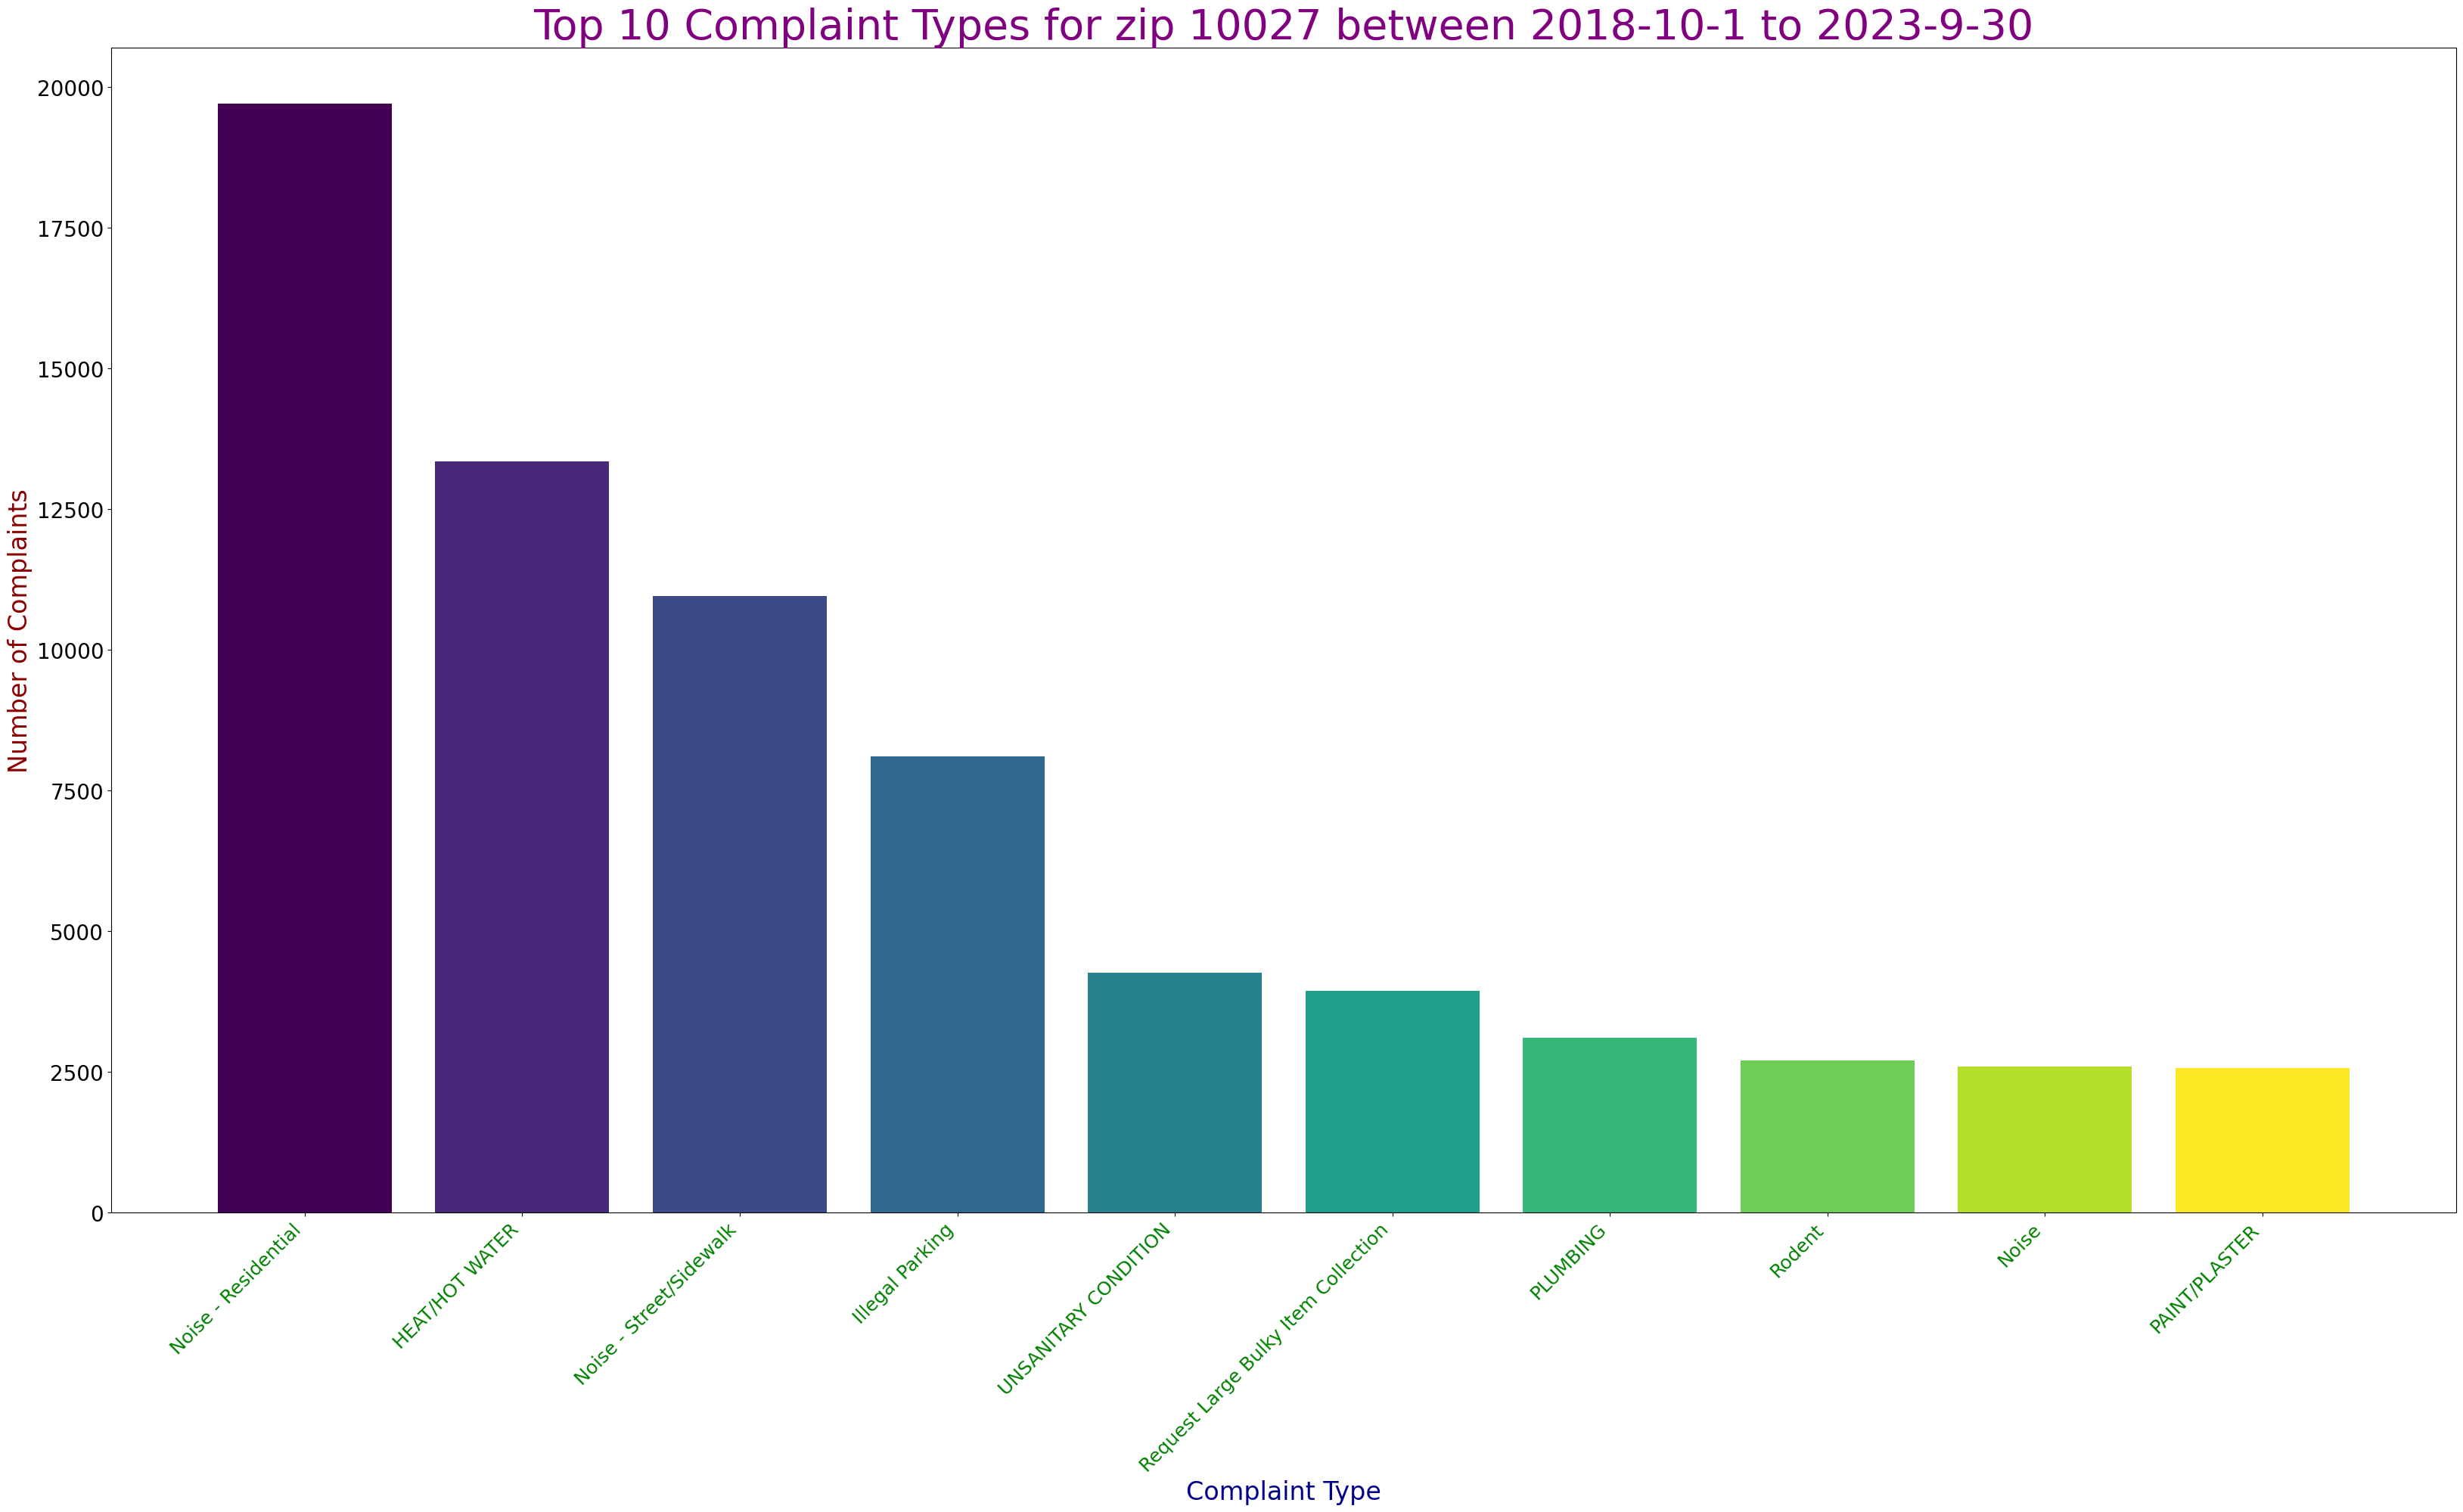

In [65]:
dataframe = get_data_for_visual_2()
plot_top_ten_complaint_type_for_10027(dataframe)

### Visualization 3

In [66]:
def plot_rent_tree_complaint_coorelation(dataframe):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
    
    dataframe = dataframe.fillna(0)

    # Plotting the first subplot (rent vs. number of trees)
    ax1.scatter(dataframe['avg_rent'], dataframe['num_trees'], color='blue', alpha=0.7)
    ax1.set_ylabel('Number of Trees', fontsize=14, color='darkblue')
    ax1.set_title('Rent vs. Number of Trees and Complaints by Zip Code', fontsize=16, color='purple')

    # Plotting the second subplot (rent vs. number of complaints)
    ax2.scatter(dataframe['avg_rent'], dataframe['num_complaints'], color='green', alpha=0.7)
    ax2.set_xlabel('Average Rent', fontsize=14, color='darkgreen')
    ax2.set_ylabel('Number of Complaints', fontsize=14, color='darkred')

    # Adjust font size for tick labels
    for ax in [ax1, ax2]:
        ax.tick_params(axis='both', labelsize=12)

    plt.show()

In [67]:
def get_data_for_visual_3():
    start_date = date(2015, 1, 1)
    end_date = date(2023, 9, 30)
    query = f'''
        SELECT
            zipcode,
            COUNT(id) AS num_complaints
        FROM
            NYC_complaints
        WHERE
            created_date BETWEEN '{start_date}' AND '{end_date}'
        GROUP BY
            zipcode
    '''
    cur.execute(query)
    complaints_result = cur.fetchall()

    df_complaints = pd.DataFrame(complaints_result, columns=['zipcode', 'num_complaints'])
    
    query = f'''
    SELECT
        zipcode,
        COUNT(id) AS num_trees
    FROM
        NYC_trees
    WHERE
        created_date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY
        zipcode
    '''

    cur.execute(query)
    trees_result = cur.fetchall()

    df_trees = pd.DataFrame(trees_result, columns=['zipcode', 'num_trees'])
    
    
    query = f'''
    SELECT
        zipcode,
        rents
    FROM
        NYC_rents r
    '''

    cur.execute(query)
    rent_result = cur.fetchall()

    # Convert to Pandas DataFrame

    df_rent = pd.DataFrame(rent_result, columns=['zipcode', 'rents'])
    df_rent['avg_rent'] = df_rent['rents'].apply(lambda x: np.nanmean(x))
    
    df_combined = pd.merge(df_complaints, df_trees, on='zipcode', how='inner')
    df_combined = pd.merge(df_combined, df_rent, on='zipcode', how='inner')
    
    return df_combined

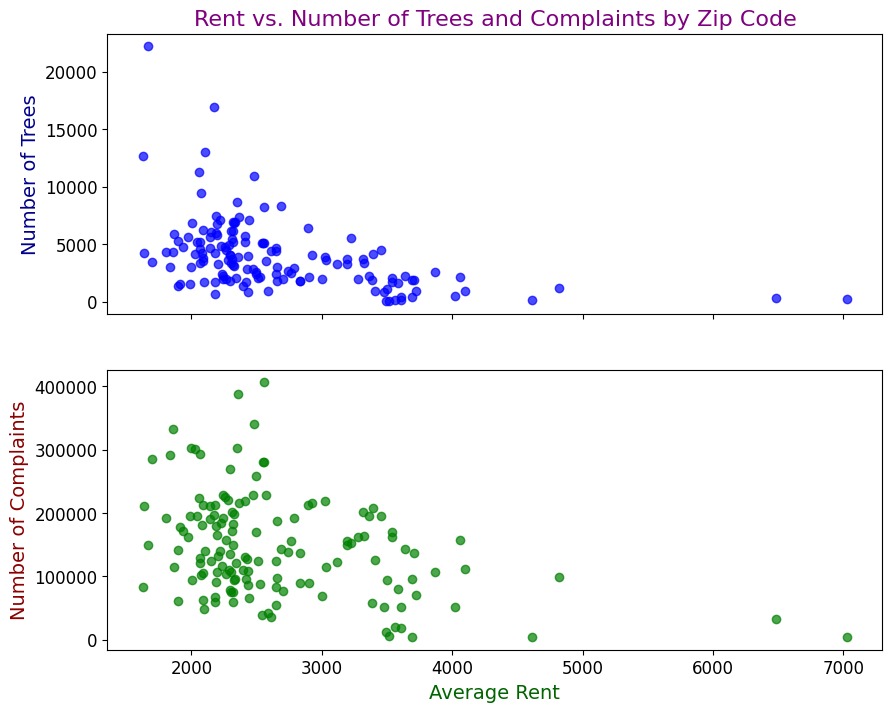

In [68]:
conn.commit()
dataframe = get_data_for_visual_3()
plot_rent_tree_complaint_coorelation(dataframe)

### Visualization 4

In [69]:
def plot_rent_complaint_coorelation(dataframe):
    # Create bins for average rent
    bins = range(0, 9000, 1000) 

    # Categorize average rent into bins
    dataframe['rent_bin'] = pd.cut(dataframe['rent'], bins, right=False)

    # Create a boxplot using Seaborn
    plt.figure(figsize=(12, 12))
    sns.boxplot(x='rent_bin', y='num_complaints', hue='rent_bin', data=dataframe, palette='viridis', dodge=True, showfliers=True, legend=False, widths=0.4)
    plt.xlabel('Average Rent Bins ($)', fontsize=14, color='darkblue')
    plt.ylabel('Number of 311 Complaints', fontsize=14, color='darkred')
    plt.title('Relationship Between Average Rent and 311 Complaints', fontsize=16, color='purple')
    plt.xticks(rotation=45)

    # Adjust font size for tick labels
    plt.xticks(fontsize=12, color='black')
    plt.yticks(fontsize=12, color='black')

    plt.show()

In [70]:
def get_data_for_visual_4():
    start_date = date(2022, 10, 1)
    end_date = date(2023, 9, 30)
    i = rent_month_dict['2023-09-30']
    QUERY = f'''
        SELECT 
            zipcode, 
            rents[{i}] AS avg_rent
        FROM 
            NYC_rents r
    '''
    cur.execute(QUERY)
    result = cur.fetchall()
    df_rent = pd.DataFrame(result, columns=['zipcode', 'rent'])
    query = f'''
        SELECT
            zipcode,
            COUNT(id) AS num_complaints
        FROM
            NYC_complaints
        WHERE
            created_date BETWEEN '{start_date}' AND '{end_date}'
        GROUP BY
            zipcode
    '''
    cur.execute(query)
    complaints_result = cur.fetchall()

    df_complaints = pd.DataFrame(complaints_result, columns=['zipcode', 'num_complaints'])
    df_combined = pd.merge(df_rent, df_complaints, on='zipcode', how='outer')
    return df_combined

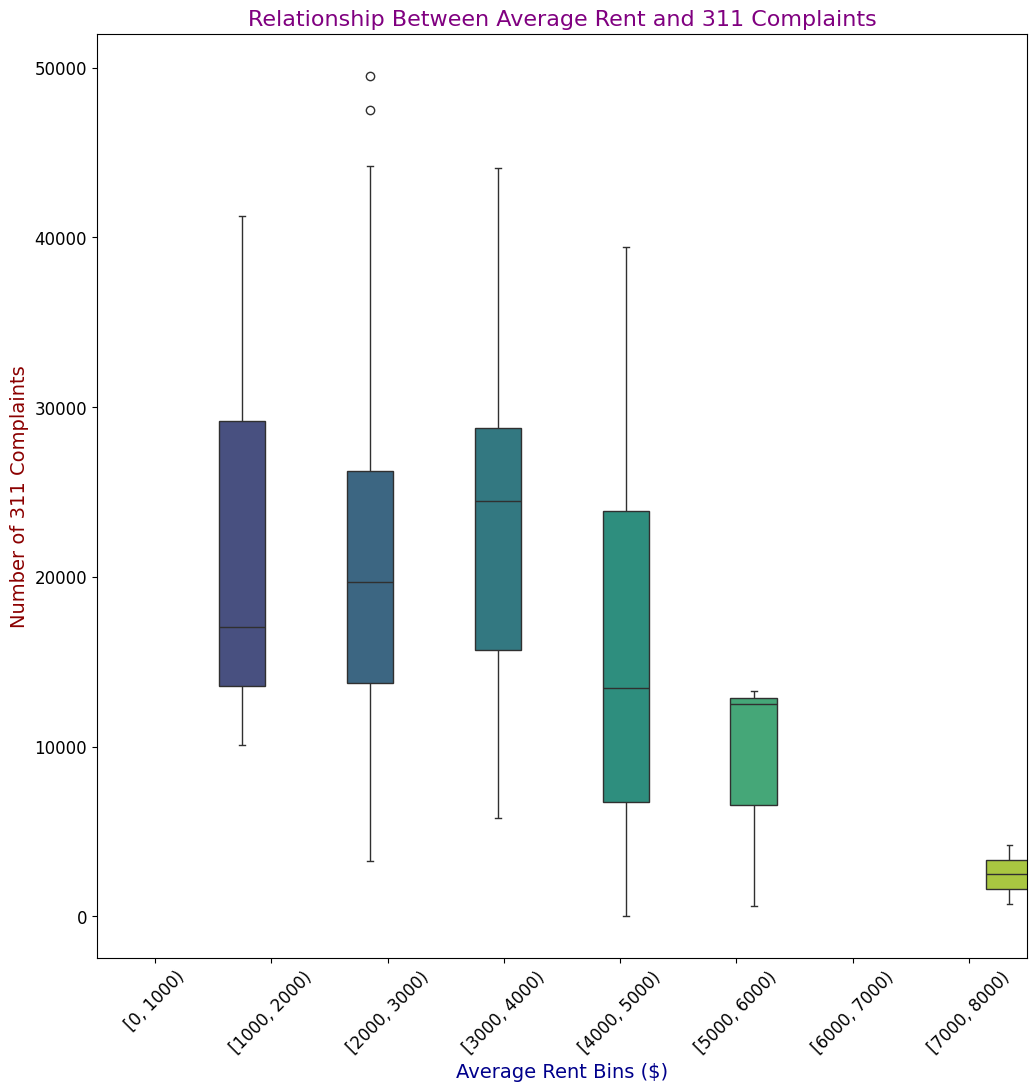

In [71]:
dataframe = get_data_for_visual_4()
plot_rent_complaint_coorelation(dataframe)

### Visualization 5

In [72]:
def plot_311_complaints_near_campus(dataframe):
    from matplotlib.patches import Circle
    
    buffer_radius = 1000  # 1 kilometer in meters
    central_coordinate = Point(-73.96253174434912, 40.80737875669467)
    buffer_geometry = central_coordinate.buffer(buffer_radius / 111000)  # Convert meters to degrees
    
    gdf_buffer = gpd.GeoDataFrame(geometry=[buffer_geometry], crs='EPSG:4326')
    
    points_within_buffer = dataframe[dataframe.geometry.within(gdf_buffer.geometry.iloc[0])]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf_buffer.plot(ax=ax, color='lightgreen', alpha=0.5, label='Buffer around Specified Coordinate')
    points_within_buffer.plot(ax=ax, color='red', markersize=50, label='311 Incidents')
    # Manually create legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='311 Incidents')]

    ax.legend(handles=legend_elements)
    
    plt.title('Geospatial Plot of 311 Incidents within 1 km Radius of Specified Coordinate')
    #legend_elements = [Patch(color='lightgreen', alpha=0.5, label='Buffer around Specified Coordinate'),
    plt.legend(handles=legend_elements)

    # Show the plot
    plt.show()

In [73]:
def get_data_for_visual_5():
    start_date = date(2023, 1, 1)
    end_date = date(2023, 9, 30)
    query = f'''
        SELECT
            id,
            created_date,
            ST_AsText(location) AS coordinate
        FROM
            NYC_complaints
        WHERE
            created_date BETWEEN '{start_date}' AND '{end_date}';
    '''
    cur.execute(query)
    complaints_result = cur.fetchall()

    df_complaints = pd.DataFrame(complaints_result, columns=['id', 'created_date', 'coordinate'])
    df_complaints["coordinate"] = gpd.GeoSeries.from_wkt(df_complaints["coordinate"])
    gdf_complaints = gpd.GeoDataFrame(df_complaints, geometry='coordinate')
    return gdf_complaints

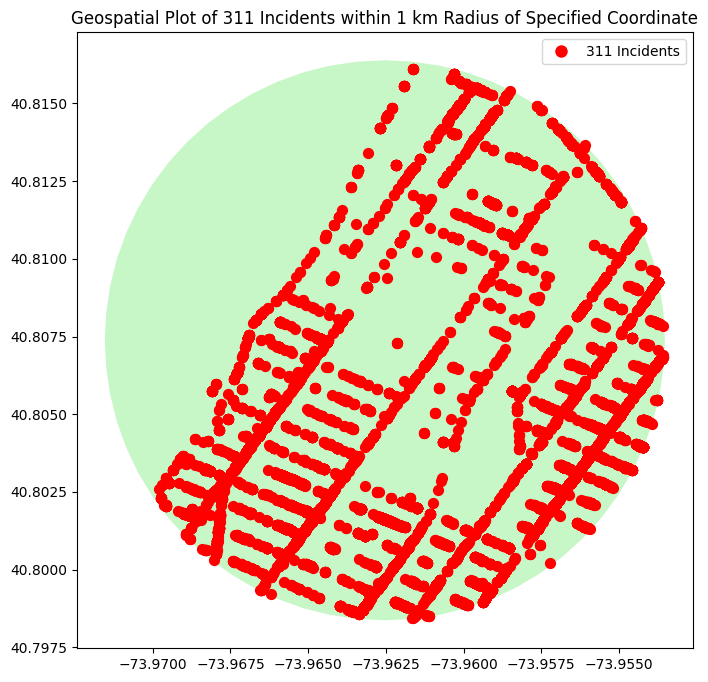

In [74]:
df = get_data_for_visual_5()
plot_311_complaints_near_campus(df)

### Visualization 6

In [75]:
def plot_NYC_trees_complaints(gdf_trees, gdf_complaints):  
    fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': gcrs.AlbersEqualArea()})

    # Plot hexbins for 311 complaints
    hb1 = ax.hexbin(
        gdf_complaints.geometry.x, gdf_complaints.geometry.y,
        gridsize=100, cmap='Blues', edgecolor='white', linewidth=0.5, mincnt=1,
        extent=[gdf_complaints.total_bounds[0], gdf_complaints.total_bounds[2], 
                gdf_complaints.total_bounds[1], gdf_complaints.total_bounds[3]]
    )

    # Plot hexbins for trees
    hb2 = ax.hexbin(
        gdf_trees.geometry.x, gdf_trees.geometry.y,
        gridsize=100, cmap='Greens', edgecolor='white', linewidth=0.5, mincnt=1,
        extent=[gdf_trees.total_bounds[0], gdf_trees.total_bounds[2], 
                gdf_trees.total_bounds[1], gdf_trees.total_bounds[3]]
    )

    # Add colorbars
    cbar1 = plt.colorbar(hb1, ax=ax, label='311 Complaints', orientation='vertical', pad=0.02)
    cbar2 = plt.colorbar(hb2, ax=ax, label='Trees', orientation='vertical', pad=0.02)

    # Set axis labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('NYC Trees and 311 Complaints Hexbin Plot')

    plt.show()

In [76]:
def get_data_for_visual_6():
    start_date = date(2018, 10, 1)
    end_date = date(2023, 9, 30)
    trees_query = f'''
        SELECT
            id,
            ST_AsText(location) AS coordinate
        FROM
            NYC_trees
    '''
    cur.execute(trees_query)
    trees_result = cur.fetchall()
    
    
    complains_query = f'''
        SELECT
            id,
            ST_AsText(location) AS coordinate
        FROM
            NYC_complaints
        WHERE
            created_date BETWEEN '{start_date}' AND '{end_date}';
    '''
    cur.execute(complains_query)
    complaints_result = cur.fetchall()
    
    df_trees = pd.DataFrame(trees_result, columns=['id', 'coordinate'])
    df_trees["coordinate"] = gpd.GeoSeries.from_wkt(df_trees["coordinate"])
    gdf_trees = gpd.GeoDataFrame(df_trees, geometry='coordinate')
    
    df_complaints = pd.DataFrame(complaints_result, columns=['id', 'coordinate'])
    df_complaints["coordinate"] = gpd.GeoSeries.from_wkt(df_complaints["coordinate"])
    gdf_complaints = gpd.GeoDataFrame(df_complaints, geometry='coordinate')
    return gdf_trees, gdf_complaints

In [77]:
gdf_trees, gdf_complaints = get_data_for_visual_6()

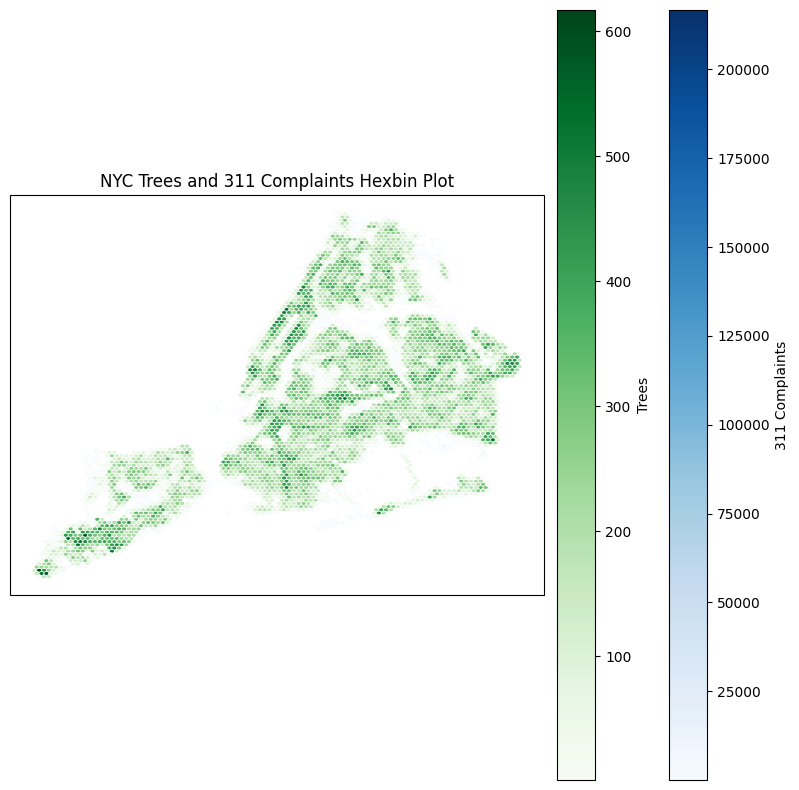

In [78]:
plot_NYC_trees_complaints(gdf_trees, gdf_complaints)